#遷移學習 resnet與inc 預測平均

### Import必要套件

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/My Drive/TFkeras/catdog.zip' /content

In [5]:
!unzip /content/catdog.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/catdog/train/dog/dog.55.jpg  
  inflating: /content/catdog/train/dog/dog.550.jpg  
  inflating: /content/catdog/train/dog/dog.5500.jpg  
  inflating: /content/catdog/train/dog/dog.5501.jpg  
  inflating: /content/catdog/train/dog/dog.5502.jpg  
  inflating: /content/catdog/train/dog/dog.5503.jpg  
  inflating: /content/catdog/train/dog/dog.5504.jpg  
  inflating: /content/catdog/train/dog/dog.5505.jpg  
  inflating: /content/catdog/train/dog/dog.5506.jpg  
  inflating: /content/catdog/train/dog/dog.5507.jpg  
  inflating: /content/catdog/train/dog/dog.5508.jpg  
  inflating: /content/catdog/train/dog/dog.5509.jpg  
  inflating: /content/catdog/train/dog/dog.551.jpg  
  inflating: /content/catdog/train/dog/dog.5510.jpg  
  inflating: /content/catdog/train/dog/dog.5511.jpg  
  inflating: /content/catdog/train/dog/dog.5512.jpg  
  inflating: /content/catdog/train/dog/dog.5513.jpg  
  inflating: /content/catdog/train/dog/dog.5514.jpg  
  inflating

### cats_vs_dogs
載入cats_vs_dogs數據集

In [6]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

In [7]:
testgenerator = ImageDataGenerator(rescale = 1./255,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
    )

In [8]:
train_dir='/content/catdog/train/'

In [9]:
test_dir='/content/catdog/test/'

In [10]:
target_size = [128, 128]
batch_size = 32

In [11]:
train_gen = generator.flow_from_directory(train_dir,
 target_size = target_size,
 batch_size = batch_size,
 shuffle=True,
 class_mode = 'categorical',                                        
 subset='training')

val_gen = generator.flow_from_directory(train_dir,
 target_size = target_size,
 batch_size = batch_size,
 shuffle=True,
 class_mode = 'categorical',                                        
 subset='validation')

test_gen = testgenerator.flow_from_directory(test_dir,
 target_size = target_size,                                          
 batch_size = 1,
 class_mode = 'categorical',                                        
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [12]:
print(train_gen.samples, val_gen.samples, test_gen.samples)

16000 4000 5000


In [13]:
print(train_gen.class_indices)

{'cat': 0, 'dog': 1}


In [14]:
# initializing label list and feeding in classes/indices
labels = [None]*len(train_gen.class_indices)

for item, indice in train_gen.class_indices.items():
    labels[indice] = item

In [15]:
labels

['cat', 'dog']

#resnet預測

In [23]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import itertools

def get_conf_matrix(model, data_dir, lenlab, size, image_size):
    prediction = []
    predictions = []
    true_y = []
    predictprob = np.empty([size, lenlab])

    ix = 0
    for x,y in testgenerator.flow_from_directory(data_dir, batch_size=1, target_size=image_size, shuffle=False):
        prediction =  model.predict(x)
        predictprob[ix,:] = prediction
        # decoding one-hot
        prediction = np.argmax(prediction, axis=1)
        y = np.argmax(y, axis =1)
        
        predictions = np.concatenate((predictions, prediction))
        true_y = np.concatenate((true_y, y))
        if len(predictions) >=size:
            break
        ix+=1
  
    matrix = confusion_matrix(true_y, predictions)

    return predictprob, matrix

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/TFkeras/resnet50.h5')
pred_resnet, conf_matrix_resnet = get_conf_matrix(model, test_dir, len(labels), test_gen.samples, target_size)
print(conf_matrix_resnet[:,:])
del model
K.clear_session()

Found 5000 images belonging to 2 classes.
[[2378  122]
 [  80 2420]]


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.9512 0.0488]
 [0.032  0.968 ]]


0.9596

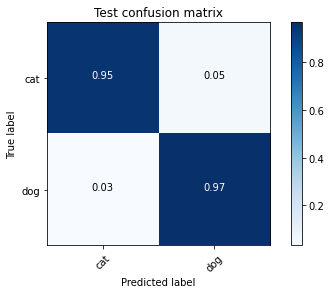

In [ ]:
plot_confusion_matrix(conf_matrix_resnet, labels, title = "Test confusion matrix")
sum([conf_matrix_resnet[i, i] for i in range(2)])/test_gen.samples

#incv3預測

In [16]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2,
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
    )

In [17]:
testgenerator = ImageDataGenerator(rescale = 1./255,
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
    )

In [25]:
model = tf.keras.models.load_model('/content/drive/My Drive/TFkeras/incv3.h5')
pred_inc, conf_matrix_inc = get_conf_matrix(model, test_dir, len(labels), test_gen.samples, target_size)
print(conf_matrix_inc[:,:])
del model
K.clear_session()

Found 5000 images belonging to 2 classes.
[[2324  176]
 [  52 2448]]


Normalized confusion matrix
[[0.9296 0.0704]
 [0.0208 0.9792]]


0.9544

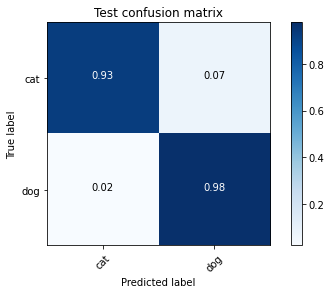

In [26]:
plot_confusion_matrix(conf_matrix_inc, labels, title = "Test confusion matrix")
sum([conf_matrix_inc[i, i] for i in range(2)])/test_gen.samples

#resnet與inc 預測平均

In [ ]:
true_y = []
for _,y in testgenerator.flow_from_directory(test_dir, batch_size=1, target_size=target_size, shuffle=False):
    # decoding one-hot
    y = np.argmax(y, axis =1)
    true_y = np.concatenate((true_y, y))
    if len(true_y)>=test_gen.samples:
        break

Found 5000 images belonging to 2 classes.


Normalized confusion matrix
[[0.9488 0.0512]
 [0.0224 0.9776]]


0.9632

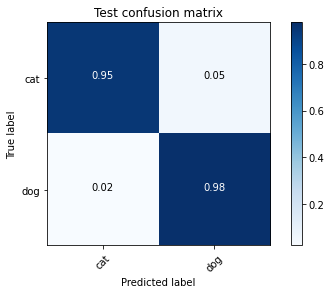

In [ ]:
predmean = (pred_resnet + pred_inc) / 2.
predictions = np.argmax(predmean, axis=1)
conf_matrix = confusion_matrix(true_y, predictions)
plot_confusion_matrix(conf_matrix, labels, title = "Test confusion matrix")
sum([conf_matrix[i, i] for i in range(2)])/test_gen.samples